<a href="https://colab.research.google.com/github/ShenghuSang/AppliedPredictiveModeling/blob/master/Simple_AD_Monte_Carlo_Greeks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Simple Monte-Carlo Greeks by AAD

This notebook compares the Greeks as calculated by Finite Difference versus Adjoint Algorithmic Differentiation (AAD) on Monte-Carlo simulated call options under Black-Scholes model.

AAD is implemented with TensorFlow. We use nested AAD to calculate 2nd order Greeks. A payoff smoother allows us to obtain the Gamma.

In [ ]:
# Import relevant modules
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import time as tm

print("TensorFlow version: " + tf.__version__)
print("NumPy version: " + np.__version__)
print("TensorFlow-Probability version: " + tfp.__version__)

TensorFlow version: 2.9.2
NumPy version: 1.21.6
TensorFlow-Probability version: 0.17.0


In [ ]:
# Parameters
expiry = 2
spot = 100.0
vol = 0.20
rate = 0.04
div = 0.01
strike = 100.0

# Bumps for differentials
spot_bump = 0.01  # Percentage of spot
vol_bump = 0.01  # Percentage of vol
time_bump = 1.0 / 365.0
rate_bump = 1.0 / 10000.0  # In bps

# Scalings
vega_scaling = 0.01  # Vega shown for 1% absolute moves
theta_scaling = 1.0 / 365.0  # Theta shown for 1d moves
rate_scaling = 1.0 / 10000.0  # DV01 shown for 1bp moves

# Random generator seed
seed = 42

In [ ]:
# Helper methods
def print_val(values):
    print("PV: {:,.4f}".format(values[0]))
    print("Delta: {:,.4f}".format(values[1]))
    print("Gamma: {:,.4f}".format(values[2]))
    print("Vega: {:,.4f}".format(values[3]))
    print("Theta: {:,.4f}".format(values[4]))
    print("DV01: {:,.4f}".format(values[5]))
    print("Volga: {:,.4f}".format(values[6]))
    print("Vanna: {:,.4f}".format(values[7]))

### 1) Standard Monte-Carlo
We implement a standard Monte-Carlo simulation with no AAD. First a function that calculates the PV by simulation, and then a bump calculator.

In [ ]:
# Standard simulator
def simulate_std(spot_, vol_, time_, rate_, gaussians):
    # Calculate deterministic forward
    fwd = spot_ * np.exp((rate_ - div) * time_)

    # Calculate final spot paths
    stdev = vol_ * np.sqrt(time_)
    future_spot = fwd * np.exp(-0.5 * stdev * stdev + stdev * gaussians)
    future_spot = future_spot[:, 0]
    
    # Calculate discounted payoff
    df = np.exp(-rate_ * time_)
    payoff = [df * max(s - strike, 0) for s in future_spot]
    
    # Reduce
    pv = np.mean(payoff)
    
    return pv

In [ ]:
# Calculation by bumps
def calculate_bumps(spot_, vol_, time_, rate_, num_mc):
    rng = np.random.RandomState(seed)
    gaussians = rng.normal(0.0, 1.0, (num_mc, 1))

    pv = simulate_std(spot_, vol_, expiry, rate_, gaussians)

    # Delta-Gamma
    spot_u = spot_ * (1.0 + spot_bump)
    pv_spot_up = simulate_std(spot_u, vol_, time_, rate_, gaussians)

    spot_d = spot_ * (1.0 - spot_bump)
    pv_spot_down = simulate_std(spot_d, vol_, time_, rate_, gaussians)

    # Vega-Volga
    vol_u = vol_ * (1.0 + vol_bump)
    pv_vol_up = simulate_std(spot_, vol_u, time_, rate_, gaussians)

    vol_d = vol_ * (1.0 - vol_bump)
    pv_vol_down = simulate_std(spot_, vol_d, time_, rate_, gaussians)

    # Theta
    pv_expiry_down = simulate_std(spot_, vol_, time_ - time_bump, rate_, gaussians)

    # DV01
    pv_rate_up = simulate_std(spot_, vol_, time_, rate_ + rate_bump, gaussians)
    pv_rate_down = simulate_std(spot_, vol_, time_, rate_ - rate_bump, gaussians)

    # Vanna
    pv_uu = simulate_std(spot_u, vol_u, time_, rate_, gaussians)
    pv_ud = simulate_std(spot_u, vol_d, time_, rate_, gaussians)
    pv_du = simulate_std(spot_d, vol_u, time_, rate_, gaussians)
    pv_dd = simulate_std(spot_d, vol_d, time_, rate_, gaussians)

    # FDM
    delta = (pv_spot_up - pv_spot_down) / (2.0 * spot_bump * spot_)
    gamma = (pv_spot_up + pv_spot_down - 2.0 * pv) / np.power(spot_bump * spot_, 2)
    vega = (pv_vol_up - pv_vol_down) / (2.0 * vol_bump * vol_) * vega_scaling 
    theta = (pv_expiry_down - pv) / time_bump * theta_scaling
    dv01 = (pv_rate_up - pv_rate_down) / (2.0 * rate_bump) * rate_scaling
    volga = (pv_vol_up + pv_vol_down - 2.0 * pv) / np.power(vol_bump * vol_, 2) * np.power(vega_scaling, 2)
    vanna = (pv_uu - pv_ud - pv_du + pv_dd) / (4.0 * spot_bump * spot_ * vol_bump * vol_) * vega_scaling
          
    return [pv, delta, gamma, vega, theta, dv01, volga, vanna]

In [ ]:
# Test bumps
num_mc = 100 * 1000
values = calculate_bumps(spot, vol, expiry, rate, num_mc)

print_val(values)

PV: 13.8276
Delta: 0.6264
Gamma: 0.0131
Vega: 0.5211
Theta: -0.0108
DV01: 0.0098
Volga: 0.0008
Vanna: -0.0013


### 2) AAD Monte-Carlo
We implement PV and Greeks using AAD. As the call payoff $Max(S - K, 0)$, function of $S$, is linear on both sides of the kink, directly using AAD produces $\Gamma = 0$. The payoff smoother is inspired by (but only loosely connected to) the Black-Scholes formula. 

In [ ]:
# AAD 2nd order simulator with smoothing
smooth_vol = 0.40
smooth_time = 10.0 / 365.0
smooth_stdev = smooth_vol * np.sqrt(smooth_time)
N = tfp.distributions.Normal(0.0, 1.0)

def smooth_max(future_spot, strike):
    d1 = tf.math.log(future_spot / strike) / smooth_stdev + 0.5 * smooth_stdev
    d2 = d1 - smooth_stdev
    N1 = N.cdf(d1)
    N2 = N.cdf(d2)
    return future_spot * N1 - 0.5 * strike * (N1 + N2)  # Average
    # return future_spot * N.cdf(d1) - strike * N.cdf(d2)  # BS, overestimates
    # return (future_spot - strike) * N.cdf(d1)  # Underestimates

def calculate_aad(spot_, vol_, time_, rate_, num_mc):
    rng = np.random.RandomState(seed)
    gaussians = rng.normal(0.0, 1.0, (num_mc, 1))

    tf_spot = tf.convert_to_tensor(spot_, dtype='float32')
    tf_vol = tf.convert_to_tensor(vol_)
    tf_time = tf.convert_to_tensor(time_, dtype='float32')
    tf_rate = tf.constant(rate_)
    tf_div = tf.constant(div)
  
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([tf_spot, tf_vol, tf_time, tf_rate])
        with tf.GradientTape(persistent=True) as tape2nd:
            tape2nd.watch([tf_spot, tf_vol])

            # Calculate deterministic forward
            fwd = tf_spot * tf.math.exp((tf_rate - tf_div) * tf_time)

            # Calculate final spot paths
            stdev = tf_vol * tf.math.sqrt(tf_time)
            future_spot = fwd * tf.math.exp(-0.5 * stdev * stdev + stdev * gaussians)
            future_spot = future_spot[:, 0]

            # Calculate discounted payoff
            df = tf.math.exp(-tf_rate * tf_time)
            payoff = df * smooth_max(future_spot, strike)

            # Reduce
            pv = tf.reduce_mean(payoff)

        # Calculate delta and vega
        g_delta = tape2nd.gradient(pv, tf_spot)
        g_vega = tape2nd.gradient(pv, tf_vol)
       
    delta = tape.gradient(pv, tf_spot)
    gamma = tape.gradient(g_delta, tf_spot)
    vega = tape.gradient(pv, tf_vol)
    theta = tape.gradient(pv, tf_time)
    dv01 = tape.gradient(pv, tf_rate)
    volga = tape.gradient(g_vega, tf_vol)
    vanna = tape.gradient(g_delta, tf_vol)
    
    # Scale
    vega = vega.numpy() * vega_scaling
    theta = -theta.numpy() * theta_scaling
    dv01 = dv01.numpy() * rate_scaling
    volga = volga.numpy() * np.power(vega_scaling, 2)
    vanna = vanna.numpy() * vega_scaling

    return [pv.numpy(), delta.numpy(), gamma.numpy(), vega, theta, dv01, volga, vanna]

In [ ]:
# Test AAD with smoothing
num_mc = 100 * 1000
values = calculate_aad(spot, vol, expiry, rate, num_mc)

print_val(values)

PV: 13.8311
Delta: 0.6263
Gamma: 0.0130
Vega: 0.5206
Theta: -0.0108
DV01: 0.0098
Volga: 0.0007
Vanna: -0.0012


### 3) Lazy Closed-Form (LCF)
*Lazy* closed-forms, i.e. calculated from the Black-Scholes price by AAD.

In [ ]:
# Calculation by closed-form
def black_scholes(spot_, vol_, time_, rate_):
    tf_spot = tf.convert_to_tensor(spot_, dtype='float32')
    tf_vol = tf.convert_to_tensor(vol_)
    tf_time = tf.convert_to_tensor(time_, dtype='float32')
    tf_rate = tf.constant(rate_)
    tf_div = tf.constant(div)
  
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([tf_spot, tf_vol, tf_time, tf_rate])
        with tf.GradientTape(persistent=True) as tape2nd:
            tape2nd.watch([tf_spot, tf_vol])

            fwd = tf_spot * tf.math.exp((tf_rate - tf_div) * tf_time)
            stdev = tf_vol * tf.math.sqrt(tf_time)
            d1 = tf.math.log(fwd / strike) / stdev + 0.5 * stdev
            d2 = d1 - stdev
            df = tf.math.exp(-tf_rate * tf_time)
            pv = df * (fwd * N.cdf(d1) - strike * N.cdf(d2))

        # Calculate delta and vega
        g_delta = tape2nd.gradient(pv, tf_spot)
        g_vega = tape2nd.gradient(pv, tf_vol)
       
    delta = tape.gradient(pv, tf_spot)
    gamma = tape.gradient(g_delta, tf_spot)
    vega = tape.gradient(pv, tf_vol)
    theta = tape.gradient(pv, tf_time)
    dv01 = tape.gradient(pv, tf_rate)
    volga = tape.gradient(g_vega, tf_vol)
    vanna = tape.gradient(g_delta, tf_vol)
    
    # Scale
    vega = vega.numpy() * vega_scaling
    theta = -theta.numpy() * theta_scaling
    dv01 = dv01.numpy() * rate_scaling
    volga = volga.numpy() * np.power(vega_scaling, 2)
    vanna = vanna.numpy() * vega_scaling

    return [pv.numpy(), delta.numpy(), gamma.numpy(), vega, theta, dv01, volga, vanna]    


In [ ]:
# Calculate with closed-form
values = black_scholes(spot, vol, expiry, rate)

print_val(values)

PV: 13.7950
Delta: 0.6255
Gamma: 0.0130
Vega: 0.5195
Theta: -0.0107
DV01: 0.0098
Volga: 0.0006
Vanna: -0.0013


### 4) Numerical Testing
We generate a ladder of spot values to draw charts comparing the bump method with AAD. This also allows us to compare speed and tune the smoothing parameter within the trade-off between smoothness of the Greeks and bias on PV.

We find that in terms of speed, AAD starts winning at high numbers of simulations, but it allows smoother Greeks even at lower number of simulations. AAD is losing time at instantiation, which can be seen by comparison to the lazy closed-form, also losing time at instantiation in spite of a extremely fast calculation time.

In [ ]:
# Ladder tests
num_points = 100  # Number of loops/points in the charts
min_s = 20.0
max_s = 200.0
spots = np.linspace(min_s, max_s, num_points, dtype='double')  # spot ladder
num_mc = 25 * 1000  # Number of simulations
print("Displaying {c:,} points over spot range [{a:,}, {b:,}]".format(c=num_points, a=min_s, b=max_s))
print("Number of simulations: {:,}".format(num_mc))

# Bump method
print("Calculating with bumps...")
results_bmp = []
time_bmp = tm.time()
for i in range(len(spots)):
    values = calculate_bumps(spots[i], vol, expiry, rate, num_mc)
    results_bmp.append(values)

time_bmp = tm.time() - time_bmp

# AAD
print("Calculating with AAD...")
results_aad = []
time_aad = tm.time()
for i in range(len(spots)):
    values = calculate_aad(spots[i], vol, expiry, rate, num_mc)
    results_aad.append(values)

time_aad = tm.time() - time_aad

# Lazy closed-form
print("Calculating with lazy closed-form...")
results_lcf = []
time_lcf = tm.time()
for i in range(len(spots)):
    values = black_scholes(spots[i], vol, expiry, rate)
    results_lcf.append(values)

time_lcf = tm.time() - time_lcf

print("Calculation complete!")
print('Runtime(Bumps): %.1f' % time_bmp + 's')
print('Runtime(AAD): %.1f' % time_aad + 's')
print('Runtime(LCF): %.1f' % time_lcf + 's')

Displaying 100 points over spot range [20.0, 200.0]
Number of simulations: 25,000
Calculating with bumps...
Calculating with AAD...
Calculating with lazy closed-form...
Calculation complete!
Runtime(Bumps): 24.2s
Runtime(AAD): 12.7s
Runtime(LCF): 6.3s


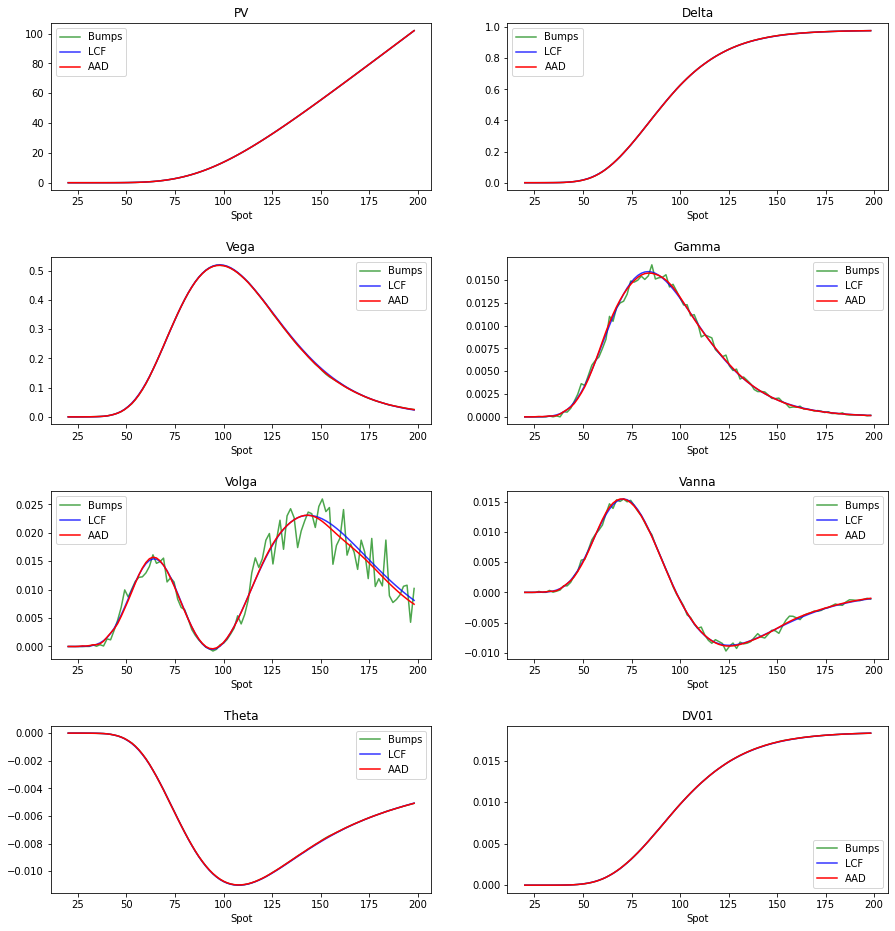

In [ ]:
results_bmp = np.array(results_bmp)
results_aad = np.array(results_aad)
results_lcf = np.array(results_lcf)

# Select viewing range
view_min = min_s  # Choose larger to zoom in
view_max = max_s  # Choose smaller to zoom in

view_range = [i for i in range(num_points) if spots[i] >= view_min and spots[i] <= view_max]
start = view_range[0]
end = view_range[-1]

def plot_value(plt_idx, name, result_idx, legend_location):
    plt.subplot(4, 2, plt_idx)
    plt.title(name)
    plt.xlabel('Spot')
    plt.plot(spots[start:end], results_bmp[start:end, result_idx], 'green', alpha=0.7, label='Bumps')
    plt.plot(spots[start:end], results_lcf[start:end:, result_idx], color='blue', alpha=0.8, label='LCF')
    plt.plot(spots[start:end], results_aad[start:end:, result_idx], color='red', label='AAD')
    plt.legend(loc=legend_location)

# Plot results
plt.ioff()
plt.figure(figsize=(15, 16))
plt.subplots_adjust(hspace=0.40, wspace=0.20)

plot_value(1, "PV", 0, 'upper left')
plot_value(2, "Delta", 1, 'upper left')
plot_value(3, "Vega", 3, 'upper right')
plot_value(4, "Gamma", 2, 'upper right')
plot_value(5, "Volga", 6, 'upper left')
plot_value(6, "Vanna", 7, 'upper right')
plot_value(7, "Theta", 4, 'upper right')
plot_value(8, "DV01", 5, 'lower right')

plt.show()